Recreating the Vision Transformer (ViT) computer vision architecture. More specifically, this is an implementation of "<a href="https://arxiv.org/abs/2010.11929">An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale</a>" ViT paper. The Transformer neural network architecture was originally introduced in the machine learning research paper "<a href="https://arxiv.org/abs/1706.03762">Attention is all you need</a>", which was designed to work on one-dimensional (1D) sequences of text.

A Transformer architecture is generally considered to be any neural network that uses the attention mechanism) as its primary learning layer. Similar to how a convolutional neural network (CNN) uses convolutions as its primary learning layer.

In [29]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torchvision import transforms
from torchinfo import summary
import torch.nn as nn

assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"

from utils import engine, data
from utils.plots import plot_loss_curves

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Data Preparation

In [8]:
# Download pizza, steak, sushi images from GitHub
image_path = data.download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi") # location is appended to '/data' inside the function
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [9]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [10]:
train_dir

PosixPath('data/pizza_steak_sushi/train')

In [11]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [12]:
# ViT paper states the use of a batch size of 4096 
# Note: We're using the pin_memory=True parameter in the create_dataloaders() function to speed up computation. 
# pin_memory=True avoids unnecessary copying of memory between the CPU and GPU memory by "pinning" examples that 
# have been seen before. Though the benefits of this will likely be seen with larger dataset sizes. However, setting 
# pin_memory=True doesn't always improve performance (this is another one of those we're scenarios in machine learning 
# where some things work sometimes and don't other times), so best to experiment.

# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fab9feacbe0>,
 ['pizza', 'steak', 'sushi'])

In [16]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

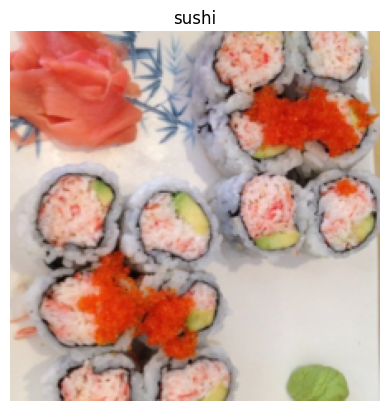

In [19]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

#### ViT Model

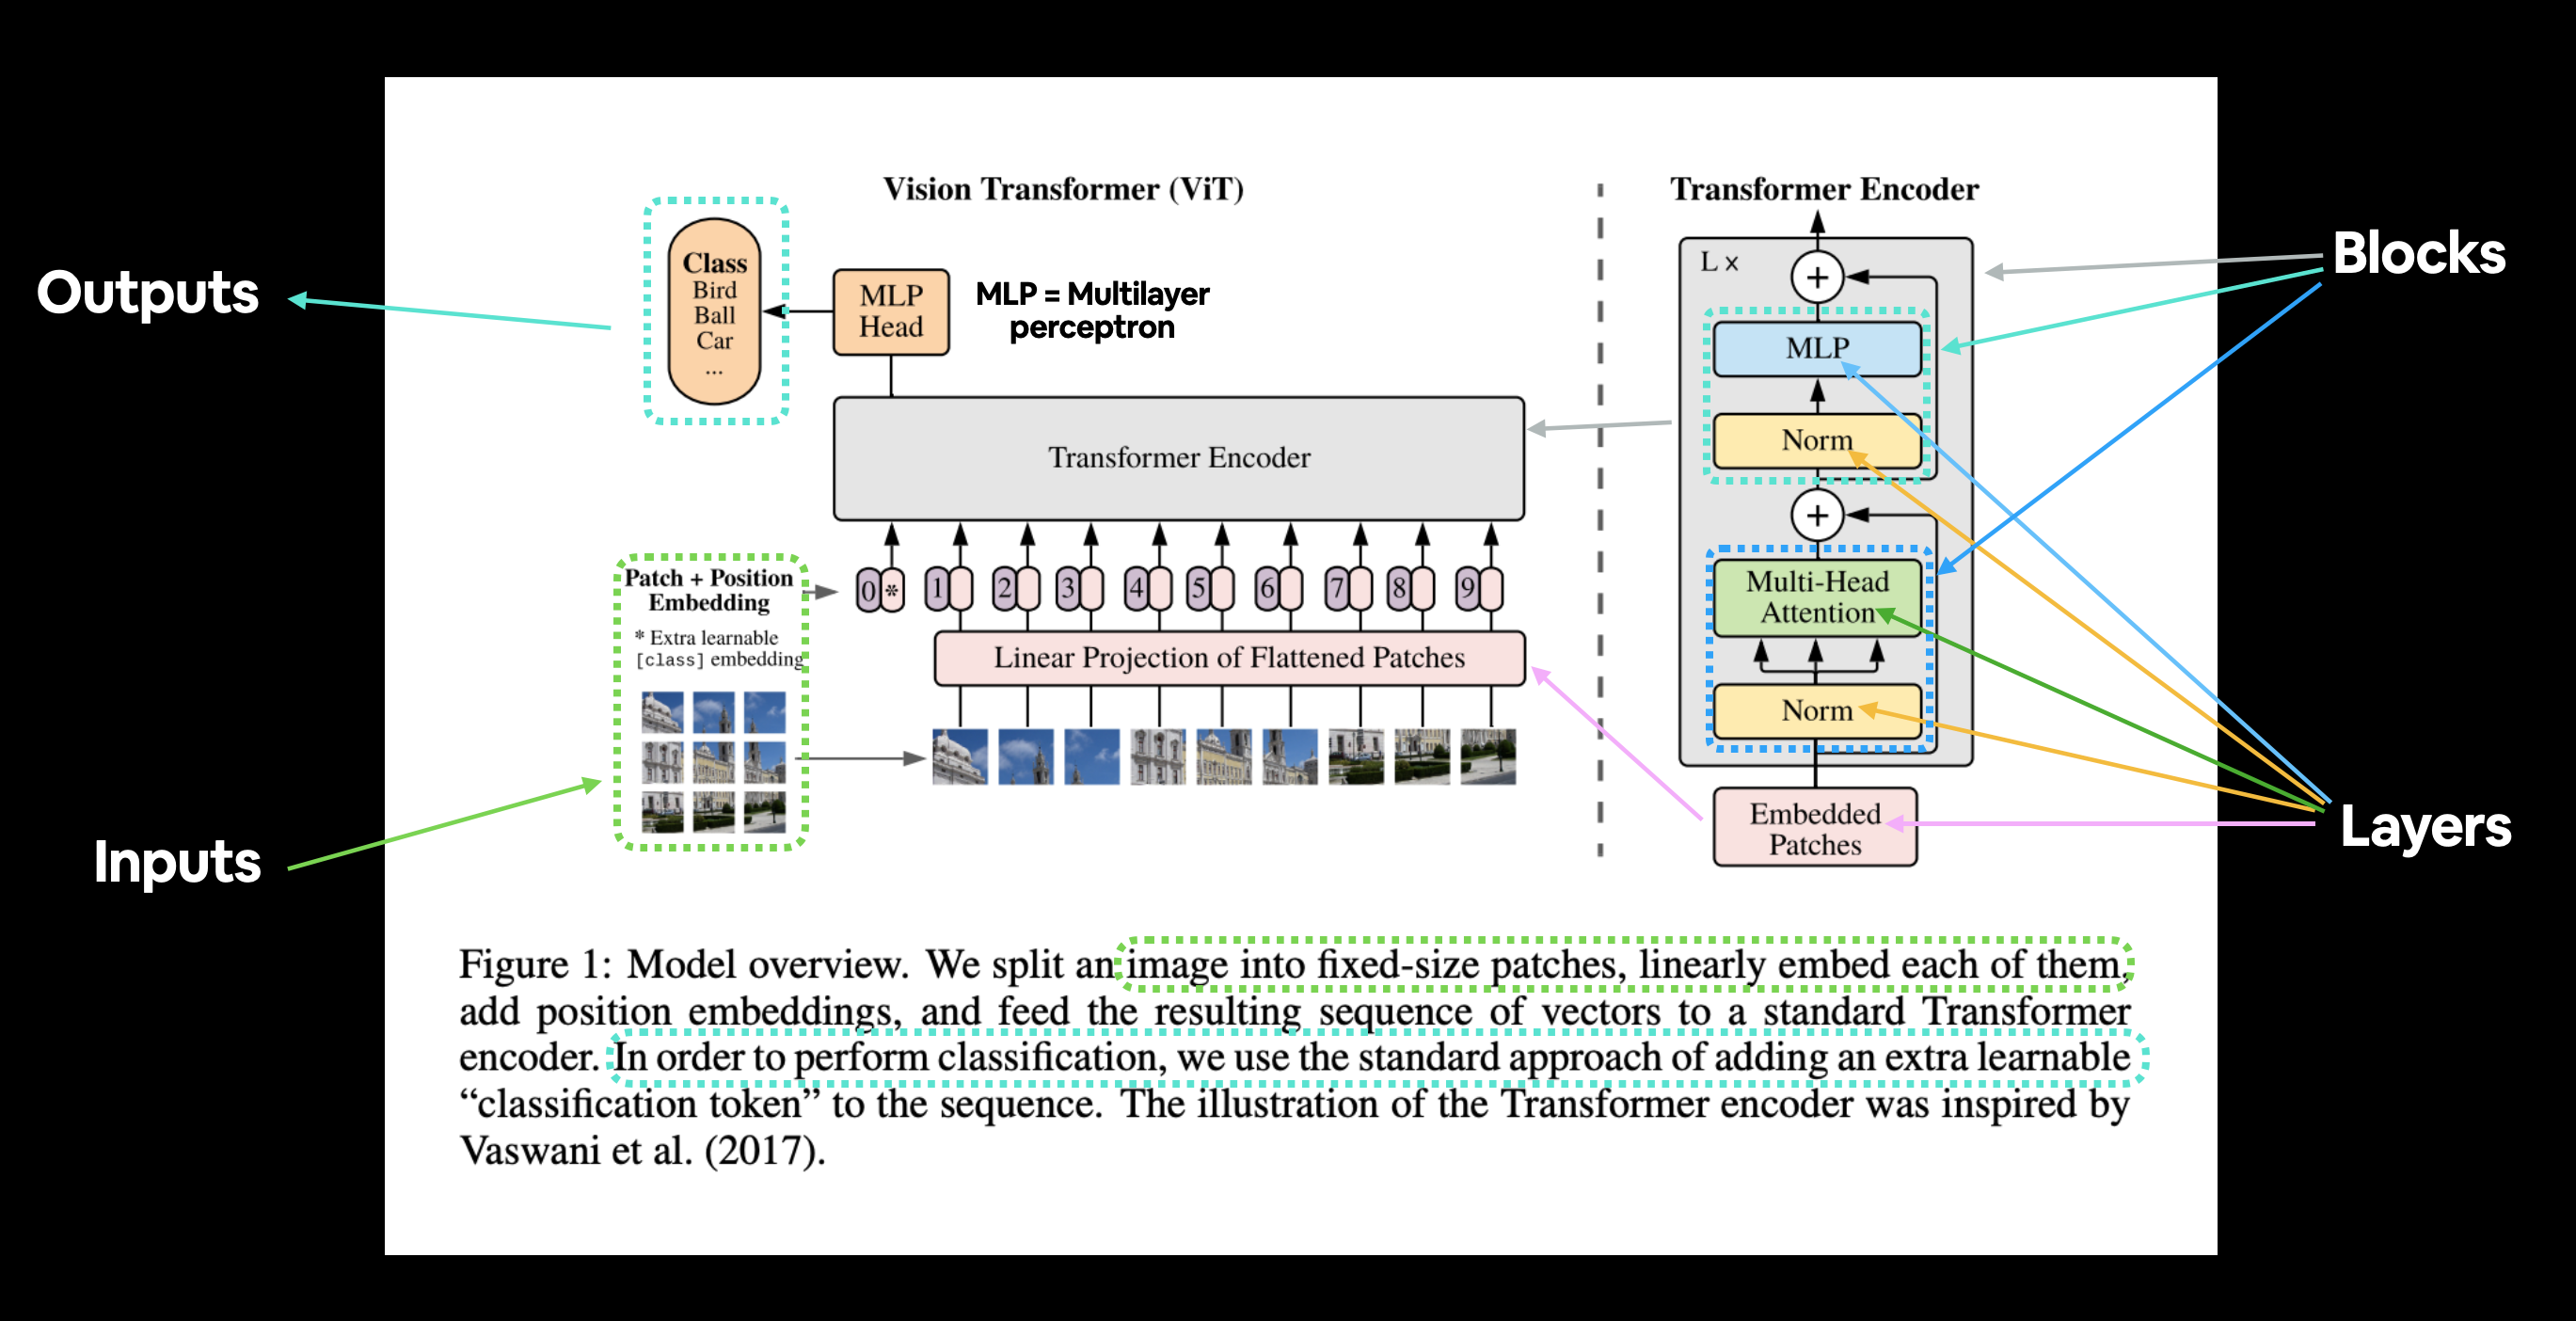

The ViT architecture is comprised of several stages:

* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
* **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an embedding, the benefit of using an embedding rather than just the image values is that an embedding is a learnable representation (typically in the form of a vector) of the image that can improve with training.
* **Norm** - This is short for "Layer Normalization" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer `torch.nn.LayerNorm()`.
* **Multi-Head Attention** - This is a Multi-Headed Self-Attention layer or "MSA" for short. You can create an MSA layer via the PyTorch layer `torch.nn.MultiheadAttention()`.
* **MLP (or Multilayer perceptron)** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a forward() method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two torch.nn.Linear() layers with a torch.nn.GELU() non-linearity activation in between them (section 3.1) and a torch.nn.Dropout() layer after each (Appendix B.1).
* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

#### Equation 1: Split data into patches and creating the class, position and patch embedding

$$ \begin{aligned} \mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \end{aligned} $$

This equation deals with the class token, patch embedding and position embedding ($\mathbf{E}$ is for embedding) of the input image.

In vector form, the embedding might look something like:

```python
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
```

From the paper:

> The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the **patch embeddings**.

* $D$ is the size of the patch embeddings, different values for $D$ for various sized ViT models can be found in Table 1.
The image starts as 2D with size ${H \times W \times C}$.
* $(H, W)$ is the resolution of the original image (height, width).
    * $C$ is the number of channels.
    * The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
* $(P, P)$ is the resolution of each image patch (patch size).
* $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.


Image size = (H,W,C) -> (N_Patches, ($P^{2}$ $\times$ C)). For example, patch size = 16 (ViT Base): 
(224, 224, 3) -> ( (224//16)$\times$(224//16) , (16$\times$16$\times$3) ) = (196, 768).

The 196 patches came from the number of patches of size 16$\times$16 in a 224 $\times$ 224 image.

In [20]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P as in Table 5 of the ViT-B/16 paper

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [21]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


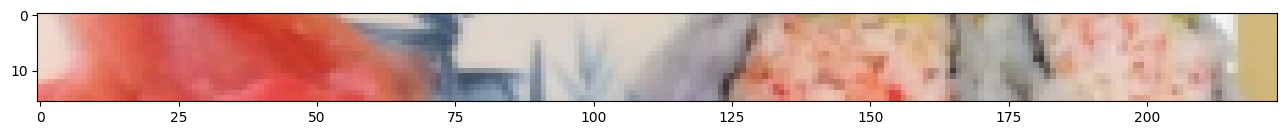

In [25]:
# Change image shape to be compatible with matplotlib (color_channels/0, height/1, width/2) -> (height/1, width/2, color_channels/0)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


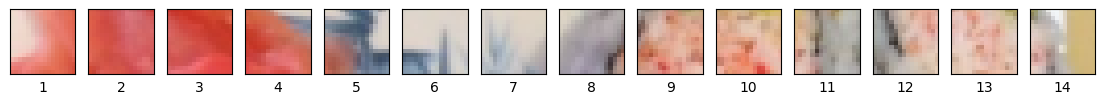

In [26]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


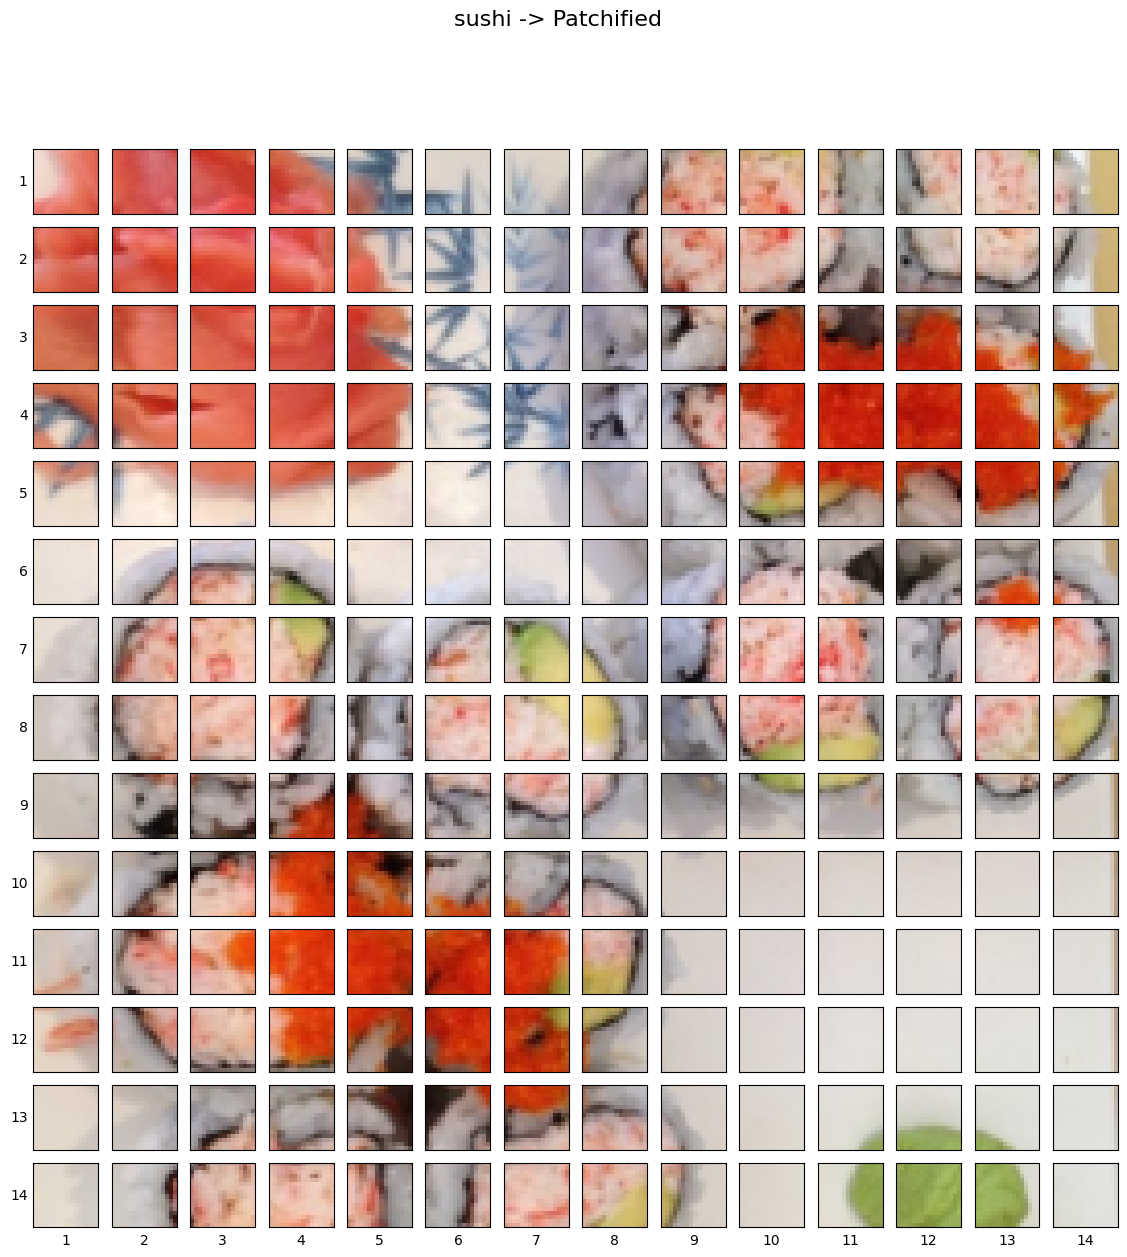

In [27]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

**Creating image patches with `torch.nn.Conv2d()`**

For an image size of 224 and patch size of 16:

* Input (2D image): (224, 224, 3) -> (height, width, color channels)
* Output (flattened 2D patches): (196, 768) -> (number of patches, embedding dimension)

We can recreate these with:

* `torch.nn.Conv2d()` for turning our image into patches of CNN feature maps.
* `torch.nn.Flatten()` for flattening the spatial dimensions of the feature map.

This means each convolutional kernel will be of size (patch_size x patch_size) or if `patch_size=16, (16 x 16)` (the equivalent of one whole patch). And each step or stride of the convolutional kernel will be `patch_size` pixels long or 16 pixels long (equivalent of stepping to the next patch).

We'll set `in_channels=3` for the number of color channels in our image and we'll set out_channels=768, the same as the $D$ value in Table 1 for ViT-Base (this is the embedding dimension, each image will be embedded into a learnable vector of size 768).

In [30]:
# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

In [31]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


The output of the convolution patches can be expressed as 

```python
torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Let's visualize five random feature maps and see what they look like.

Showing random convolutional feature maps from indexes: [542, 678, 562, 295, 623]


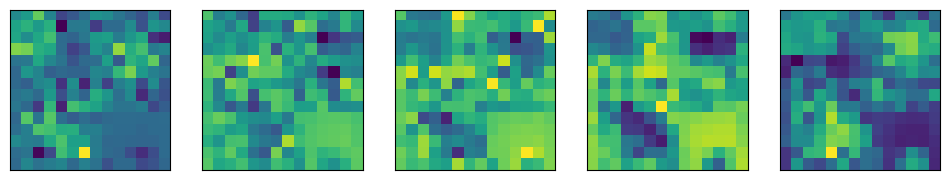

In [33]:

# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 767), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);


In [34]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.3560,  0.2396,  0.2496,  0.3826,  0.3282,  0.5923,  0.4974,
            0.3685,  0.5586,  0.4124,  0.4282,  0.3855,  0.4114,  0.5015],
          [ 0.2324,  0.2131,  0.2263,  0.2901,  0.4582,  0.5582,  0.4775,
            0.4155,  0.3437,  0.2516,  0.3828,  0.2881,  0.5087,  0.3353],
          [ 0.2396,  0.2555,  0.1830,  0.2410,  0.3103,  0.4374,  0.5066,
            0.3599,  0.2927,  0.2510,  0.1901,  0.2165,  0.4130,  0.4997],
          [ 0.3155,  0.3495,  0.2682,  0.2284,  0.2549,  0.6184,  0.5132,
            0.3862,  0.2526,  0.1074,  0.0386,  0.0434,  0.1205,  0.2835],
          [ 0.4751,  0.5017,  0.3943,  0.3312,  0.3734,  0.6416,  0.6384,
            0.4516,  0.4661,  0.4881,  0.2336,  0.1632,  0.2452,  0.3898],
          [ 0.5808,  0.4903,  0.5527,  0.3531,  0.5584,  0.5911,  0.5462,
            0.4720,  0.4601,  0.4644,  0.5881,  0.5714,  0.3697,  0.4552],
          [ 0.5718,  0.4584,  0.4587,  0.3901,  0.4930,  0.4943,  0.3822,
            0.4741,  0.2800,  0.

We've turned our image into patch embeddings but they're still in 2D format. To get them into the desired output shape (1D sequence of flatten 2D patches): (196, 768) -> (number of patches, embedding dimension), we can flatten them:

In [35]:
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [36]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


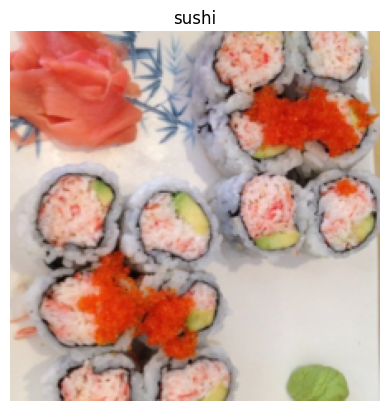

In [37]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [38]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


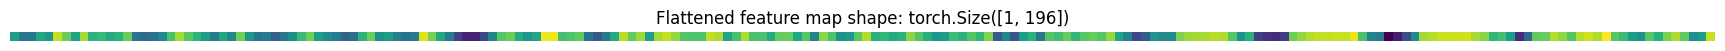

In [39]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [40]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [45]:
batch_size = 10
summary(PatchEmbedding(), input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
PatchEmbedding                           [10, 196, 768]            --
├─Conv2d: 1-1                            [10, 768, 14, 14]         590,592
├─Flatten: 1-2                           [10, 768, 196]            --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (G): 1.16
Input size (MB): 6.02
Forward/backward pass size (MB): 12.04
Params size (MB): 2.36
Estimated Total Size (MB): 20.43

https://www.learnpytorch.io/08_pytorch_paper_replicating/#45-turning-the-vit-patch-embedding-layer-into-a-pytorch-module